In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option("display.max_columns",100)

### Importing Data

In [3]:
train = pd.read_csv(r"I:/HackerEarth/AmExpert/Data/train.csv")
test  = pd.read_csv(r"I:/HackerEarth/AmExpert/Data/test.csv")

#### General Information About The Datasets

In [4]:
print (f"Shape of Training Data is : {train.shape}")
print (f"Shape of Testing Data is : {test.shape}")

Shape of Training Data is : (45528, 19)
Shape of Testing Data is : (11383, 18)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              45528 non-null  object 
 1   name                     45528 non-null  object 
 2   age                      45528 non-null  int64  
 3   gender                   45528 non-null  object 
 4   owns_car                 44981 non-null  object 
 5   owns_house               45528 non-null  object 
 6   no_of_children           44754 non-null  float64
 7   net_yearly_income        45528 non-null  float64
 8   no_of_days_employed      45065 non-null  float64
 9   occupation_type          45528 non-null  object 
 10  total_family_members     45445 non-null  float64
 11  migrant_worker           45441 non-null  float64
 12  yearly_debt_payments     45433 non-null  float64
 13  credit_limit             45528 non-null  float64
 14  credit_limit_used(%)  

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              11383 non-null  object 
 1   name                     11383 non-null  object 
 2   age                      11383 non-null  int64  
 3   gender                   11383 non-null  object 
 4   owns_car                 11251 non-null  object 
 5   owns_house               11383 non-null  object 
 6   no_of_children           11193 non-null  float64
 7   net_yearly_income        11383 non-null  float64
 8   no_of_days_employed      11278 non-null  float64
 9   occupation_type          11383 non-null  object 
 10  total_family_members     11352 non-null  float64
 11  migrant_worker           11357 non-null  float64
 12  yearly_debt_payments     11361 non-null  float64
 13  credit_limit             11383 non-null  float64
 14  credit_limit_used(%)  

#### Checking Missing Values 

In [7]:
train.isna().sum()

customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   547
owns_house                   0
no_of_children             774
net_yearly_income            0
no_of_days_employed        463
occupation_type              0
total_family_members        83
migrant_worker              87
yearly_debt_payments        95
credit_limit                 0
credit_limit_used(%)         0
credit_score                 8
prev_defaults                0
default_in_last_6months      0
credit_card_default          0
dtype: int64

In [8]:
test.isna().sum()

customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   132
owns_house                   0
no_of_children             190
net_yearly_income            0
no_of_days_employed        105
occupation_type              0
total_family_members        31
migrant_worker              26
yearly_debt_payments        22
credit_limit                 0
credit_limit_used(%)         0
credit_score                 3
prev_defaults                0
default_in_last_6months      0
dtype: int64

1. 6 columns are of object data type, rest are either integers or floating point values.
2. 7 columns have missing values in total. And the percentage of missing values as compared to the size of the dataset is very low.

### Univariate Analysis

### EDA - Dependent Variable

In [9]:
train['credit_card_default'].value_counts(normalize=True)

0   0.919
1   0.081
Name: credit_card_default, dtype: float64

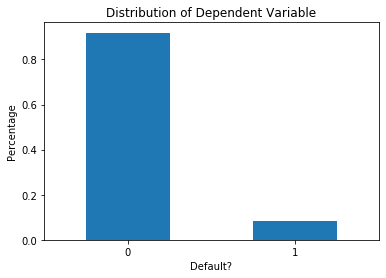

In [10]:
train['credit_card_default'].value_counts(normalize=True).plot.bar();
plt.title("Distribution of Dependent Variable");
plt.xlabel("Default?");
plt.ylabel("Percentage");
plt.xticks(rotation=360);

We can see that the data is imbalanced, around 8.1% of the customers have defaulted on the credit card bills. 

### EDA - Independent Variables

#### Customer_ID Variable

In [11]:
print (f"Number of Unique Customers in Training Data are:{train['customer_id'].nunique()}")
print (f"Number of Unique Customers in Testing Data are:{test['customer_id'].nunique()}")

Number of Unique Customers in Training Data are:45528
Number of Unique Customers in Testing Data are:11383


In [12]:
# Let's ccheck if there is overlap in the customers between the two datasets, there are no overlaps.
set(train['customer_id']).intersection(set(test['customer_id']))

set()

In [13]:
# We will delete the customer_id and name variables as they are of no use in the model building
Submissions = test[['customer_id']]
train.drop(['customer_id','name'],axis=1,inplace=True)
test.drop(['customer_id','name'],axis=1,inplace=True)

#### Age Variable

In [14]:
train['age'].describe()

count   45528.000
mean       38.993
std         9.544
min        23.000
25%        31.000
50%        39.000
75%        47.000
max        55.000
Name: age, dtype: float64

In [15]:
test['age'].describe()

count   11383.000
mean       39.073
std         9.572
min        23.000
25%        31.000
50%        39.000
75%        47.000
max        55.000
Name: age, dtype: float64

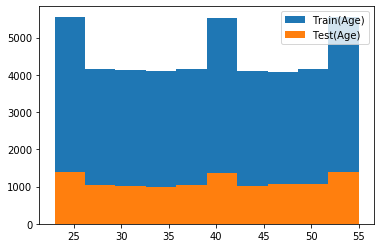

In [16]:
plt.hist(train['age'],bins=10, label='Train(Age)')
plt.hist(test['age'],bins=10, label='Test(Age)')
plt.legend(loc='upper right')
plt.show()

1. We can see that the distribution of Age variable is almost the same in both training and testing datasets.
2. Maximum, Median, Minimum Age are same in both datasets.

#### Gender Variable

In [17]:
train['gender'].value_counts(dropna=False,normalize=True)

F     0.658
M     0.342
XNA   0.000
Name: gender, dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


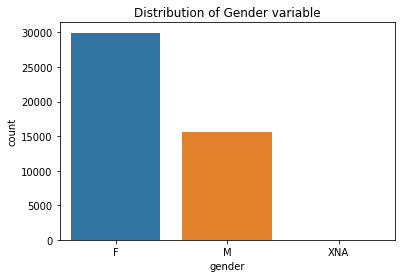

In [18]:
sns.countplot(train['gender']);
plt.title("Distribution of Gender variable");

In [19]:
test['gender'].value_counts(dropna=False,normalize=True)

F     0.654
M     0.346
XNA   0.000
Name: gender, dtype: float64

1. We can see that around 65% of the customers are Female, followed by 34% Male, this is true for both datasets.
2. We also see a value XNA, which might be missing value encoded as XNA.

In [20]:
# replacing XNA in gender column with the mode. 
train['gender'].replace({"XNA":"F"},inplace=True)
test['gender'].replace({"XNA":"F"},inplace=True)

#### Owns Car Variable

In [21]:
train['owns_car'].value_counts(dropna=False,normalize=True)

N     0.653
Y     0.335
NaN   0.012
Name: owns_car, dtype: float64

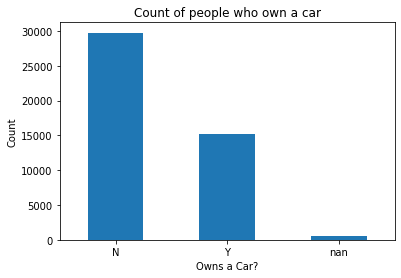

In [22]:
train['owns_car'].value_counts(dropna=False).plot.bar();
plt.title("Count of people who own a car");
plt.xticks(rotation=360);
plt.xlabel("Owns a Car?");
plt.ylabel("Count");

In [23]:
test['owns_car'].value_counts(dropna=False,normalize=True)

N     0.648
Y     0.341
NaN   0.012
Name: owns_car, dtype: float64

1. 65% of the customers do not own a car and 33% own a car. 
2. We also have around 1.2% missing data in this variable. 

#### Owns House Variable

In [24]:
train['owns_house'].value_counts(dropna=False,normalize=True)

Y   0.695
N   0.305
Name: owns_house, dtype: float64

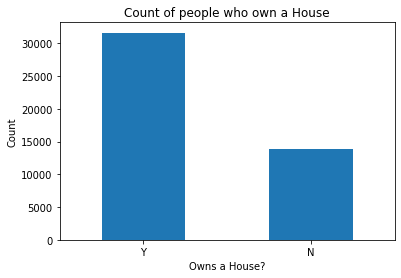

In [25]:
train['owns_house'].value_counts(dropna=False).plot.bar();
plt.title("Count of people who own a House");
plt.xticks(rotation=360);
plt.xlabel("Owns a House?");
plt.ylabel("Count");

In [26]:
test['owns_house'].value_counts(dropna=False,normalize=True)

Y   0.691
N   0.309
Name: owns_house, dtype: float64

The distribution of customers who own a house is same across both datasets. Around 70% own a house and the rest don't. No missing values in this variable.

#### Number of Children Variable

In [27]:
train['no_of_children'].value_counts(dropna=False)

0.000    31241
1.000     8985
2.000     3862
nan        774
3.000      584
4.000       60
5.000       13
6.000        6
7.000        1
9.000        1
8.000        1
Name: no_of_children, dtype: int64

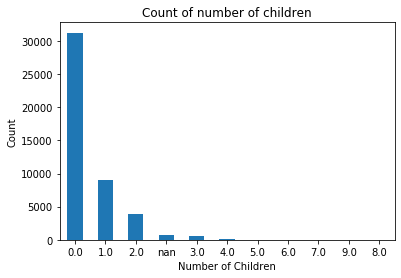

In [28]:
train['no_of_children'].value_counts(dropna=False).plot.bar();
plt.title("Count of number of children");
plt.xticks(rotation=360);
plt.xlabel("Number of Children");
plt.ylabel("Count");

In [29]:
test['no_of_children'].value_counts(dropna=False)

0.000     7825
1.000     2248
2.000      957
nan        190
3.000      138
4.000       19
5.000        4
11.000       1
7.000        1
Name: no_of_children, dtype: int64

1. The maximum number of children a customer has is 9 in the training dataset whereas it is 11 in test set.
2. There are missing values in this variable in both datasets.
3. Number of unique values is 10 in the training dataset whereas it is 8 in the test set.
4. Most of the customers do not have children in both datasets followed by 1 child.

In [30]:
train['no_of_children'] = train['no_of_children'].map({0:"0",1:"1",2:"2",3:"3",4:"4",5:"4+",6:"4+",7:"4+",8:"4+",9:"4+"})
test['no_of_children'] = test['no_of_children'].map({0:"0",1:"1",2:"2",3:"3",4:"4",5:"4+",7:"4+",11:"4+"})

In [31]:
train['no_of_children'].fillna("Missing",inplace=True)
test['no_of_children'].fillna("Missing",inplace=True)

In [32]:
train['no_of_children'] = train['no_of_children'].map({"0":0,"1":1,"2":2,"3":3,"4":4,"4+":5,"Missing":-999})
test['no_of_children'] = test['no_of_children'].map({"0":0,"1":1,"2":2,"3":3,"4":4,"4+":5,"Missing":-999})

#### Net Yearly Income Variable

In [33]:
train['net_yearly_income'].describe()

count       45528.000
mean       200655.622
std        669074.035
min         27170.610
25%        126345.835
50%        171714.910
75%        240603.760
max     140759012.730
Name: net_yearly_income, dtype: float64

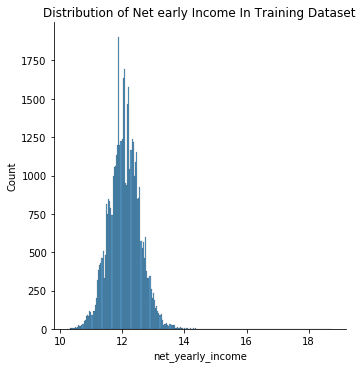

In [34]:
sns.displot(np.log1p(train['net_yearly_income']));
plt.title("Distribution of Net early Income In Training Dataset");

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


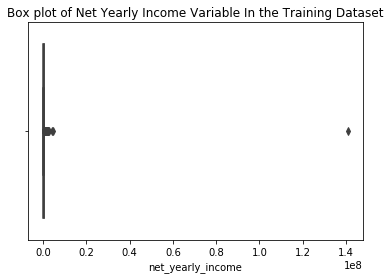

In [35]:
sns.boxplot(train['net_yearly_income']);
plt.title("Box plot of Net Yearly Income Variable In the Training Dataset");

In [36]:
test['net_yearly_income'].describe()

count     11383.000
mean     198708.405
std      115190.519
min       30309.940
25%      127447.930
50%      172869.500
75%      240233.860
max     2472450.200
Name: net_yearly_income, dtype: float64

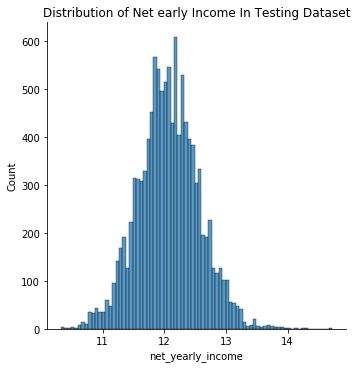

In [37]:
sns.displot(np.log1p(test['net_yearly_income']));
plt.title("Distribution of Net early Income In Testing Dataset");

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


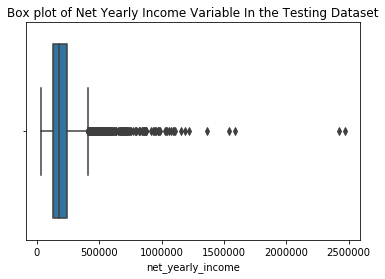

In [38]:
sns.boxplot(test['net_yearly_income']);
plt.title("Box plot of Net Yearly Income Variable In the Testing Dataset");

1. Log transormed histograms of net yearly income variable in both the datasets looks normally distributed.
2. Training dataset has one value which is way ahead of the rest, might be an outlier.
3. Testing dataset also has some outliers that have to be explored further.

#### Outliers in Net Yearly Income Variable.

In [39]:
Q1 = train['net_yearly_income'].quantile(0.25)
Q3 = train['net_yearly_income'].quantile(0.75)
IQR = Q3-Q1
print (f"Values of Net Yearly Income below {Q1-1.5*IQR} and above {Q3+1.5*IQR} in the Training dataset can be considered as outliers")

Values of Net Yearly Income below -45041.052500000005 and above 411990.6475 in the Training dataset can be considered as outliers


In [40]:
train[train['net_yearly_income']>5000000]

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
26662,51,F,N,Y,1,140759012.730,924.000,Laborers,3.000,0.000,32825.600,31129970.490,82,526.000,0,1,1


The above observation can be dropped or imputed as it clearly looks to be a data entry error.

In [41]:
# Replacing the outlier values in the income variable with the mean income without the record.
mean_income = train.drop(train.loc[train['net_yearly_income']>4000000].index)['net_yearly_income'].mean()
train.loc[train['net_yearly_income']>4000000,'net_yearly_income'] = mean_income

#### Number of Days Employed Variable

In [42]:
train['no_of_days_employed'].describe()

count    45065.000
mean     67609.289
std     139323.524
min          2.000
25%        936.000
50%       2224.000
75%       5817.000
max     365252.000
Name: no_of_days_employed, dtype: float64

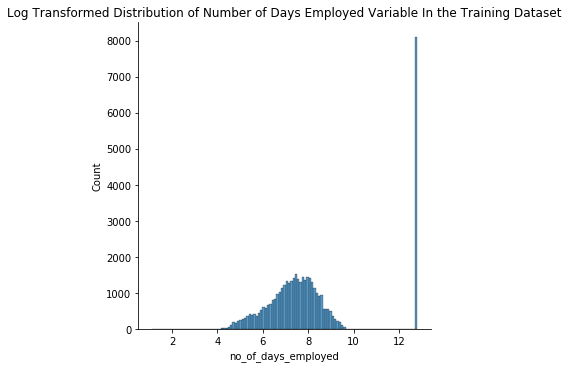

In [43]:
sns.displot(np.log1p(train['no_of_days_employed']));
plt.title("Log Transformed Distribution of Number of Days Employed Variable In the Training Dataset");

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


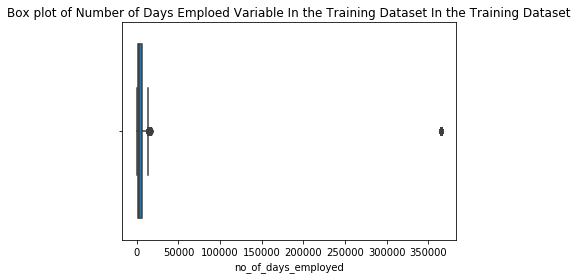

In [44]:
sns.boxplot(train['no_of_days_employed']);
plt.title("Box plot of Number of Days Emploed Variable In the Training Dataset In the Training Dataset");

In [45]:
test['no_of_days_employed'].describe()

count    11278.000
mean     65519.798
std     137572.107
min         -3.000
25%        934.250
50%       2216.000
75%       5517.000
max     365252.000
Name: no_of_days_employed, dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


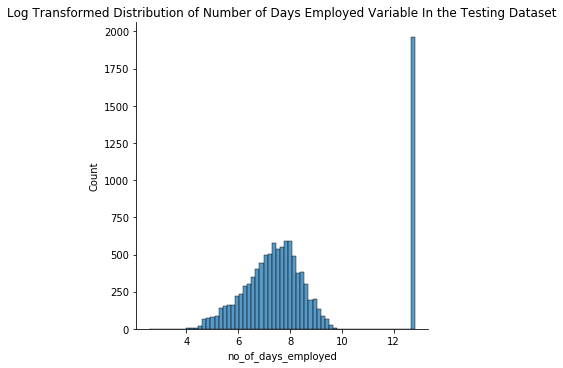

In [46]:
sns.displot(np.log1p(test['no_of_days_employed']));
plt.title("Log Transformed Distribution of Number of Days Employed Variable In the Testing Dataset");

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


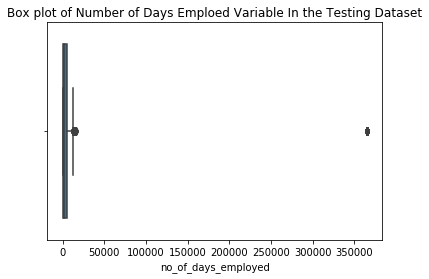

In [47]:
sns.boxplot(test['no_of_days_employed']);
plt.title("Box plot of Number of Days Emploed Variable In the Testing Dataset");

1. We can see some extreme values for Number Of Days Employed variable in both training and testing datasets.
2. We can also see some negative values in the testing dataset.
3. The maximum value of number of das emploed variable in both datasets is 365252 which becomes 1000 years, this is practically not possible. We might have to either delete that record or impute it with suitable value.
4. Since there are lot of records with these high values of number of days employed, we cannot delete them, we will impute them with median value. Also, for all these records, the occupation type is Unknown.

In [48]:
# Replacing extreme values of no of days employed variable in the training and test datasets.
train.loc[train['no_of_days_employed']>300000,'no_of_days_employed'] = train['no_of_days_employed'].median()
test.loc[test['no_of_days_employed']>300000,'no_of_days_employed'] = test['no_of_days_employed'].median()
test.loc[test['no_of_days_employed']<0,'no_of_days_employed'] = test['no_of_days_employed'].median()

#### Occupation Type Variable

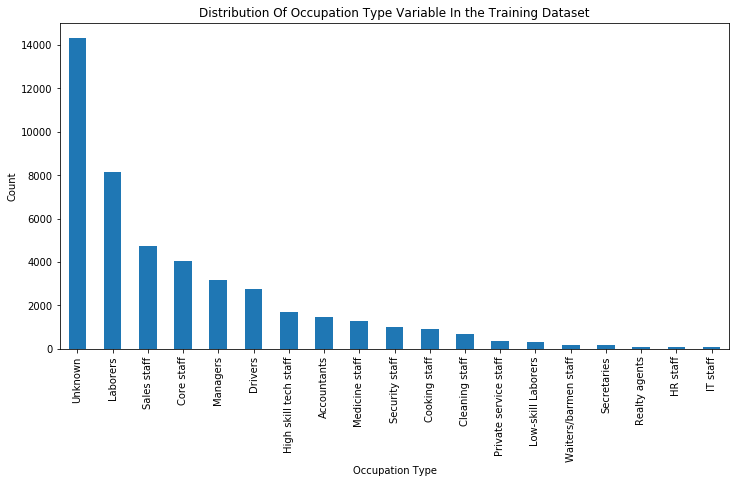

In [49]:
plt.figure(figsize=(12,6));
train['occupation_type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution Of Occupation Type Variable In the Training Dataset");
plt.xlabel("Occupation Type");
plt.ylabel("Count");
plt.xticks(rotation=90);

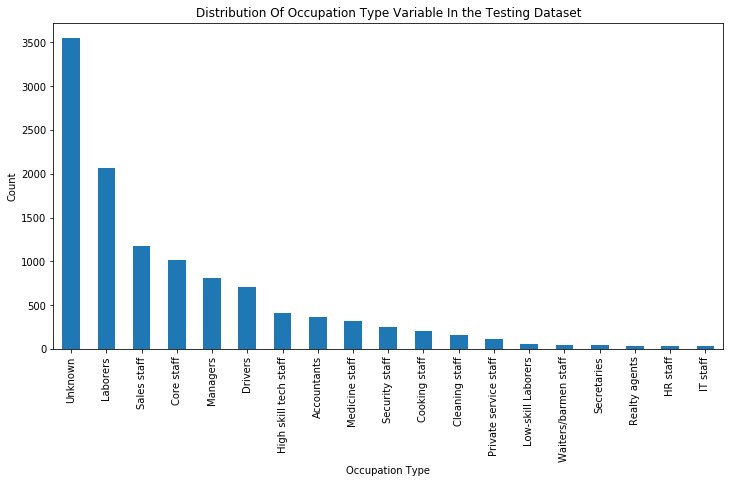

In [50]:
plt.figure(figsize=(12,6));
test['occupation_type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution Of Occupation Type Variable In the Testing Dataset");
plt.xlabel("Occupation Type");
plt.ylabel("Count");
plt.xticks(rotation=90);

1. There are no missing values in this variable in either of the datasets.
2. Unknown seems to be the most common occupation type followed by Laborers and Sales Staff. IT staff is the least popular. 

#### Total Family Members Variable.

In [51]:
train['total_family_members'].value_counts(dropna=False)

2.000     23455
1.000      9913
3.000      7812
4.000      3623
5.000       564
nan          83
6.000        57
7.000        12
8.000         6
10.000        2
9.000         1
Name: total_family_members, dtype: int64

In [52]:
test['total_family_members'].value_counts(dropna=False)

2.000     5835
1.000     2493
3.000     1961
4.000      907
5.000      131
nan         31
6.000       19
7.000        4
13.000       1
9.000        1
Name: total_family_members, dtype: int64

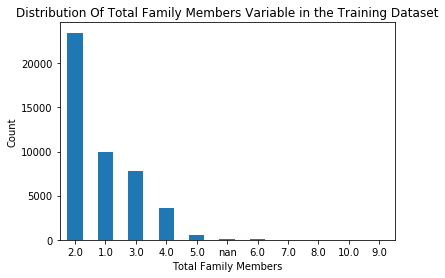

In [53]:
train['total_family_members'].value_counts(dropna=False).plot.bar();
plt.title("Distribution Of Total Family Members Variable in the Training Dataset");
plt.xlabel("Total Family Members");
plt.ylabel("Count");
plt.xticks(rotation=360);

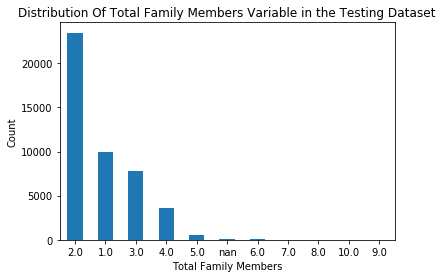

In [54]:
train['total_family_members'].value_counts(dropna=False).plot.bar();
plt.title("Distribution Of Total Family Members Variable in the Testing Dataset");
plt.xlabel("Total Family Members");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. There are a few missing values in this variable.
2. Most of the customers have a family of 2 followed by single members. 

In [55]:
train['total_family_members'] = train['total_family_members'].map({1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7+",8:"7+",9:"7+",10:"7+"})
test['total_family_members'] = test['total_family_members'].map({1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7+",9:"7+",13:"7+"})

In [56]:
train['total_family_members'].fillna("Missing",inplace=True)
test['total_family_members'].fillna("Missing",inplace=True)

In [57]:
train['total_family_members'] = train['total_family_members'].map({"0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7+":7,"Missing":-999})
test['total_family_members'] = test['total_family_members'].map({"0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7+":7,"Missing":-999})

#### Migrant Worker Variable

In [58]:
train['migrant_worker'].value_counts(dropna=False,normalize=True)

0.000   0.819
1.000   0.179
nan     0.002
Name: migrant_worker, dtype: float64

In [59]:
test['migrant_worker'].value_counts(dropna=False,normalize=True)

0.000   0.820
1.000   0.178
nan     0.002
Name: migrant_worker, dtype: float64

1. Most of the customers in either Training and Testing datasets are not migrant workers.
2. There are some missing values in this variable. 

In [60]:
# Filling missing values in the migrant worker variable
train['migrant_worker'].fillna(0,inplace=True)
test['migrant_worker'].fillna(0,inplace=True)

#### Yearly Debt Payments Variable

In [61]:
train['yearly_debt_payments'].describe()

count    45433.000
mean     31796.965
std      17269.727
min       2237.470
25%      19231.140
50%      29081.650
75%      40561.150
max     328112.860
Name: yearly_debt_payments, dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


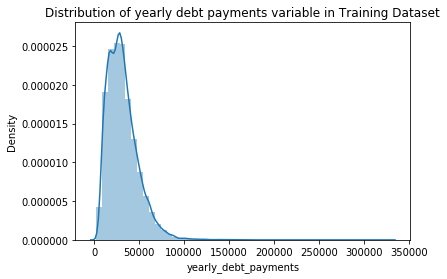

In [62]:
sns.distplot(train['yearly_debt_payments']);
plt.title("Distribution of yearly debt payments variable in Training Dataset");

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


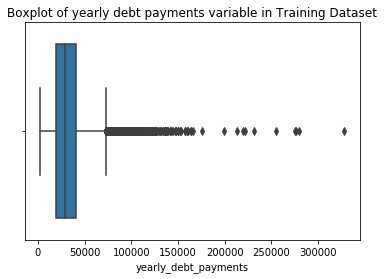

In [63]:
sns.boxplot(train['yearly_debt_payments']);
plt.title("Boxplot of yearly debt payments variable in Training Dataset");

#### Outliers in Yearly Debt Payments Variable.

In [64]:
Q1 = train['yearly_debt_payments'].quantile(0.25)
Q3 = train['yearly_debt_payments'].quantile(0.75)
IQR = Q3-Q1
print (f"Values of yearly debt repayments below {Q1-1.5*IQR} and above {Q3+1.5*IQR} in the Training dataset can be considered as outliers")

Values of yearly debt repayments below -12763.875000000004 and above 72556.16500000001 in the Training dataset can be considered as outliers


In [65]:
test['yearly_debt_payments'].describe()

count    11361.000
mean     32078.968
std      17417.413
min       2371.740
25%      19522.320
50%      29246.110
75%      40729.260
max     280114.740
Name: yearly_debt_payments, dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


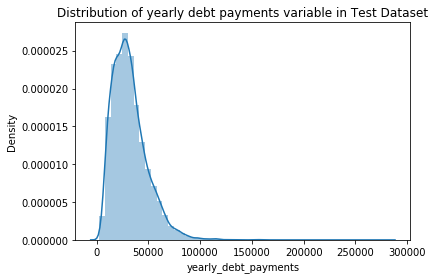

In [66]:
sns.distplot(test['yearly_debt_payments']);
plt.title("Distribution of yearly debt payments variable in Test Dataset");

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


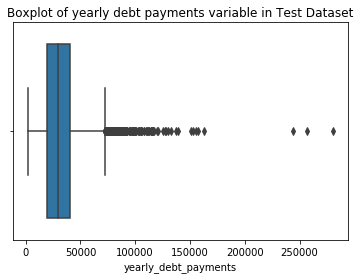

In [67]:
sns.boxplot(test['yearly_debt_payments']);
plt.title("Boxplot of yearly debt payments variable in Test Dataset");

We can see some outliers in this variable in both Training and Test datasets.

#### Credit Limit Variable

In [68]:
train['credit_limit'].describe()

count      45528.000
mean       43548.416
std       148784.687
min         4003.140
25%        23973.805
50%        35688.045
75%        53435.762
max     31129970.490
Name: credit_limit, dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


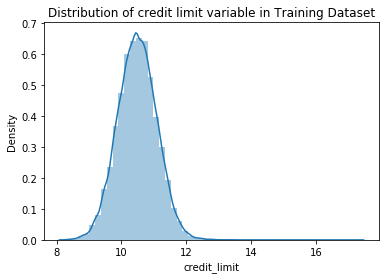

In [69]:
sns.distplot(np.log1p(train['credit_limit']));
plt.title("Distribution of credit limit variable in Training Dataset");

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


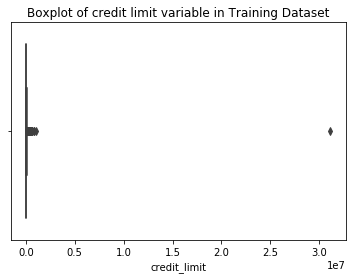

In [70]:
sns.boxplot(train['credit_limit']);
plt.title("Boxplot of credit limit variable in Training Dataset");

In [71]:
test['credit_limit'].describe()

count    11383.000
mean     42972.207
std      29325.713
min       3604.650
25%      24148.525
50%      35793.490
75%      53527.890
max     421517.090
Name: credit_limit, dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


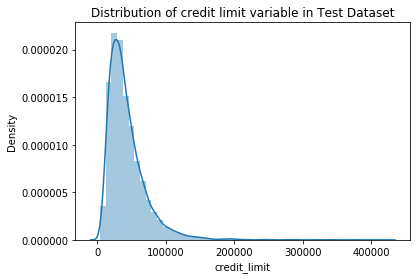

In [72]:
sns.distplot(test['credit_limit']);
plt.title("Distribution of credit limit variable in Test Dataset");

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


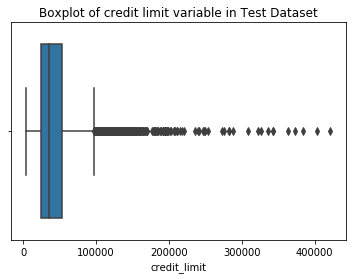

In [73]:
sns.boxplot(test['credit_limit']);
plt.title("Boxplot of credit limit variable in Test Dataset");

We can see 1 extreme value of credit limit in the trainin dataset, we have to impute it with some value.

In [74]:
train.sort_values(by='credit_limit',ascending=False).head(1)

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
26662,51,F,N,Y,1,197387.441,924.000,Laborers,3,0.000,32825.600,31129970.490,82,526.000,0,1,1


In [75]:
mean_credit_limit = train.drop(train.loc[train['credit_limit']>30000000].index)['credit_limit'].mean()
train.loc[train['credit_limit'].idxmax(),'credit_limit'] = mean_credit_limit

#### Credit Limit Used Variable

In [76]:
train['credit_limit_used(%)'].describe()

count   45528.000
mean       52.235
std        29.377
min         0.000
25%        27.000
50%        54.000
75%        78.000
max        99.000
Name: credit_limit_used(%), dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


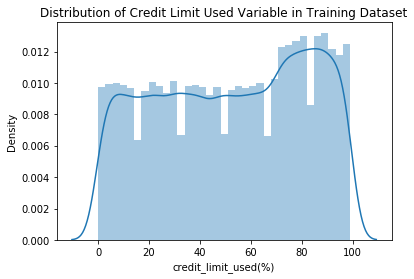

In [77]:
sns.distplot(train['credit_limit_used(%)']);
plt.title("Distribution of Credit Limit Used Variable in Training Dataset");

In [78]:
test['credit_limit_used(%)'].describe()

count   11383.000
mean       51.781
std        29.386
min         0.000
25%        26.000
50%        53.000
75%        78.000
max        99.000
Name: credit_limit_used(%), dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


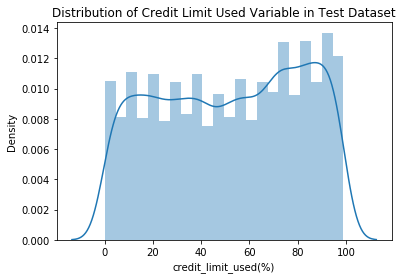

In [79]:
sns.distplot(test['credit_limit_used(%)']);
plt.title("Distribution of Credit Limit Used Variable in Test Dataset");

1. As we can see from thr distribution plot of credit limit used variable in both training and test datasets, we observe that the clusters are more thick in the training datasets as compared to test dataset.
2. The minimum credit limit used is 0 and maximum is 99%.
3. In both datasets, majority of the customers hae used more than 80% of the credit limit available.

#### Credit Score Variable

In [80]:
train['credit_score'].describe()

count   45520.000
mean      782.791
std       100.620
min       500.000
25%       704.000
50%       786.000
75%       867.000
max       949.000
Name: credit_score, dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


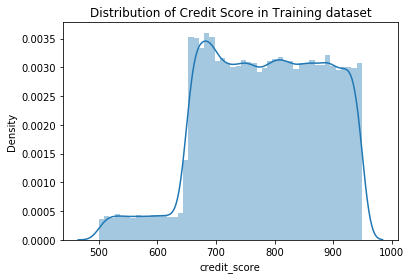

In [81]:
sns.distplot(train['credit_score']);
plt.title("Distribution of Credit Score in Training dataset");

In [82]:
test['credit_score'].describe()

count   11380.000
mean      784.389
std       100.469
min       500.000
25%       705.000
50%       787.000
75%       870.000
max       949.000
Name: credit_score, dtype: float64

C:\Users\kulka\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


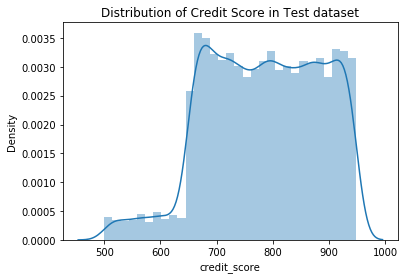

In [83]:
sns.distplot(test['credit_score']);
plt.title("Distribution of Credit Score in Test dataset");

1. Minimum, Maximum credit score in both datasets is the same.
2. Majority of customers have credit scores more than 650 in both datasets, there is a clear distinction between two roups of credit scores in both datasets.
3. May be binning will help.

#### previous defaults variable

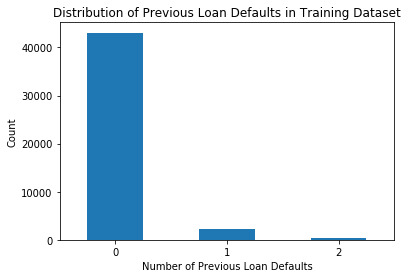

In [84]:
train['prev_defaults'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Previous Loan Defaults in Training Dataset");
plt.xlabel("Number of Previous Loan Defaults");
plt.ylabel("Count");
plt.xticks(rotation=360);

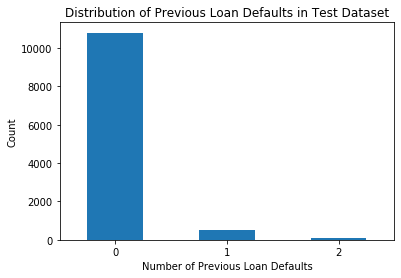

In [85]:
test['prev_defaults'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Previous Loan Defaults in Test Dataset");
plt.xlabel("Number of Previous Loan Defaults");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. In both datasets, majority of customers have not defaulted on the prevous loans.
2. Few of them have defaulted on 1 loan and few on 2 previous loans.

#### Default in last 6 months Variable

In [86]:
train['default_in_last_6months'].value_counts(dropna=False)

0    43227
1     2301
Name: default_in_last_6months, dtype: int64

In [87]:
test['default_in_last_6months'].value_counts(dropna=False)

0    10829
1      554
Name: default_in_last_6months, dtype: int64

We can see that maority of the customers have not defaulted on a loan in last 6 months in both training and test datasets.

### Bi-Variate Analysis 

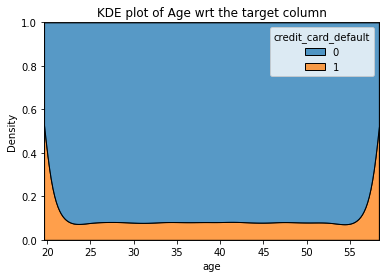

In [88]:
# Let's see the relationship between Age and credit default.
sns.kdeplot(data=train,x='age',hue='credit_card_default',multiple='fill');
plt.title("KDE plot of Age wrt the target column");

We do not see any relationship here, the probability of default remains the same across all ages. 

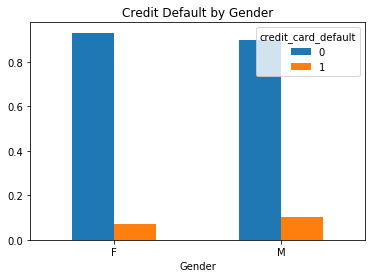

In [89]:
# Let's see the relationship between gender and credit default
train.groupby('gender')['credit_card_default'].value_counts(dropna=False,normalize=True).unstack().plot.bar();
plt.title("Credit Default by Gender");
plt.xlabel("Gender");
plt.xticks(rotation=360);

We can see that Male customers have a slightly higher chance of defaulting as compared to Female customers. This might be because there are fewer male customers as compared to female customers.

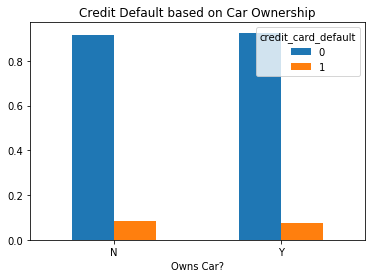

In [90]:
# let's check the relationship between the dependent variable and owns a car variable.
# We can see that the percentage of default is same if the customer owns a car or not.
train.groupby('owns_car')['credit_card_default'].value_counts(dropna=False,normalize=True).unstack().plot.bar();
plt.title("Credit Default based on Car Ownership");
plt.xlabel("Owns Car?");
plt.xticks(rotation=360);

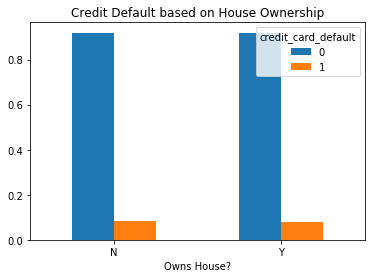

In [91]:
# let's check the relationship between the dependent variable and owns a house variable.
# We can see that the percentage of default is same if the customer owns a House or not.
train.groupby('owns_house',)['credit_card_default'].value_counts(dropna=False,normalize=True).unstack().plot.bar();
plt.title("Credit Default based on House Ownership");
plt.xlabel("Owns House?");
plt.xticks(rotation=360);

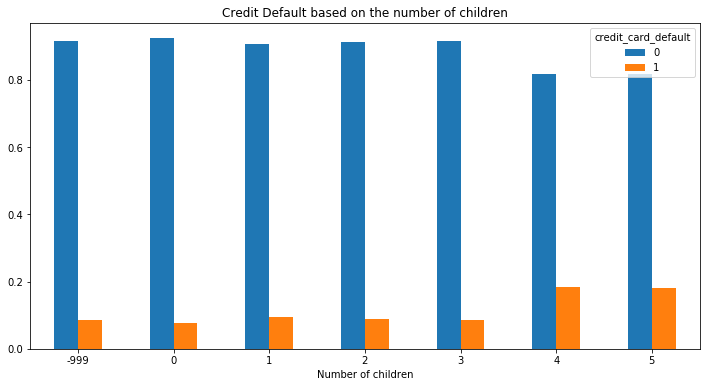

In [92]:
# let's check the relationship between the dependent variable and the number of children.
train.groupby('no_of_children')['credit_card_default'].value_counts(dropna=False,normalize=True).unstack().plot.bar(figsize=(12,6));
plt.title("Credit Default based on the number of children");
plt.xlabel("Number of children");
plt.xticks(rotation=360);

We can see that as the number of chhildren increases, the chances of defaulting also increase to some extent, interestingly, there are no defaults, with 6,7 or 8 children, this may be because their count is low. 

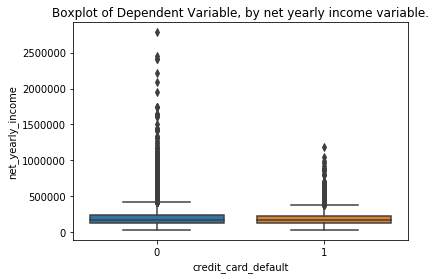

In [93]:
# Let's see the relationship between net yearly income and the dependent variable.
sns.boxplot(x='credit_card_default',y='net_yearly_income',data=train);
plt.title("Boxplot of Dependent Variable, by net yearly income variable.");

We can see that the income levels of both defaulters and no defaulters is the same. Although the non-defaulters incomes have some high values.

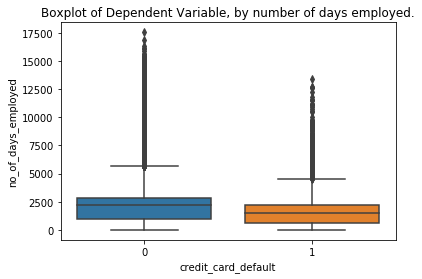

In [94]:
# Let's see the relationship between number of days employed and the dependent variable.
sns.boxplot(x='credit_card_default',y='no_of_days_employed',data=train);
plt.title("Boxplot of Dependent Variable, by number of days employed.");

We can see that the non defaulters are employed for slightly longer duration than the defaulters.

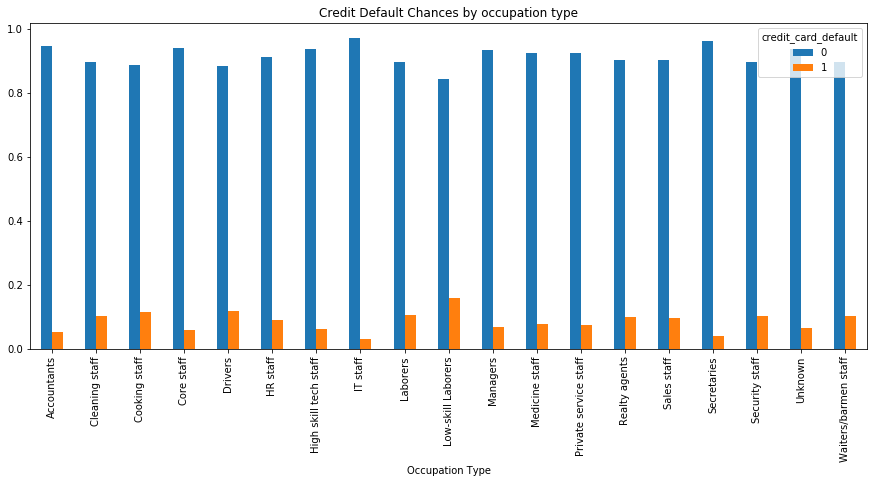

In [95]:
# Let's see the relationship between occupation type and the dependent variable.
train.groupby('occupation_type')['credit_card_default'].value_counts(normalize=True).unstack().plot.bar(figsize=(15,6));
plt.title("Credit Default Chances by occupation type");
plt.xlabel("Occupation Type");

We can see that low-skill laborers have highest chance of defaulting among all occupation types, followed by drivers, cooking staff etc.

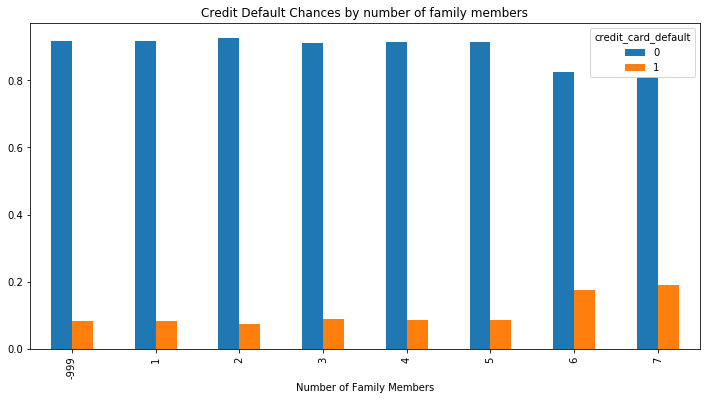

In [96]:
# Let's see the relationship between total family members and the dependent variable.
train.groupby('total_family_members')['credit_card_default'].value_counts(normalize=True).unstack().plot.bar(figsize=(12,6));
plt.title("Credit Default Chances by number of family members");
plt.xlabel("Number of Family Members");

We can see that the chance of defaulting increase with increase in the number of family members. But there are no defaults with 8, 9 family members, this might be because of the low count of customers with 8 or 9 family members.

In [97]:
# Let's see if being migrant labor has any chance of defaulting
# We can see that being a migrant worker does not increase the chance of defaulting on the credit card.
pd.crosstab(train['migrant_worker'],train['credit_card_default'],margins=True,normalize=True)

credit_card_default,0,1,All
migrant_worker,,,
0.0,0.758,0.063,0.821
1.0,0.161,0.018,0.179
All,0.919,0.081,1.000


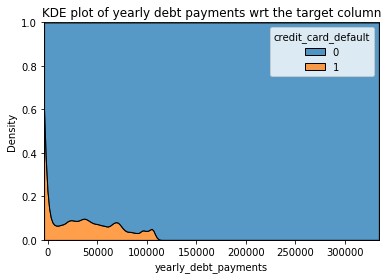

In [98]:
# Let's see the relationship between yearly debt payments and credit default.
sns.kdeplot(data=train,x='yearly_debt_payments',hue='credit_card_default',multiple='fill');
plt.title("KDE plot of yearly debt payments wrt the target column");

We can see that the chance of default decreases with increase in yearly debt payments, this is to the contrary to the common notion that as the yearly payments increase, the chance of defaulting increases.

It increases untill certain amount, but decreases after that.

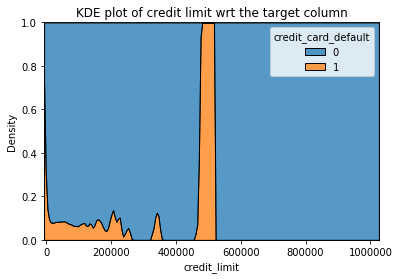

In [99]:
# Let's see the relationship between credit limit and credit default.
sns.kdeplot(data=train,x='credit_limit',hue='credit_card_default',multiple='fill');
plt.title("KDE plot of credit limit wrt the target column");

1. Well, the graph looks a bit strange, chances of default are highest when the credit limit is between 400000 and 600000. 
2. Otherwise it is less than 10%.

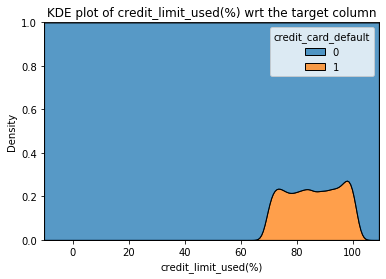

In [100]:
# Let's see the relationship between credit limit used and credit default.
sns.kdeplot(data=train,x='credit_limit_used(%)',hue='credit_card_default',multiple='fill');
plt.title("KDE plot of credit_limit_used(%) wrt the target column");

We can see that only the customers who have used more than 60% of their credit limit run the risk of defaulting, for the rest of the customers there is very meagre chance that they default on the credit card.

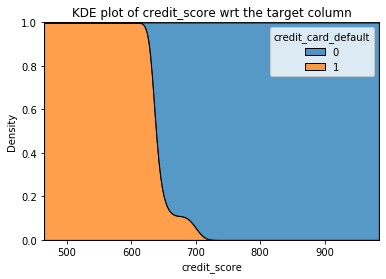

In [101]:
# Let's see the relationship between credit score and credit default.
sns.kdeplot(data=train,x='credit_score',hue='credit_card_default',multiple='fill');
plt.title("KDE plot of credit_score wrt the target column");

1. If the customer's credit score is 700+ the risk of defaulting looks like 0.
2. Customers with credit score less than 650 have a higher chance of defaulting on the credit card.

In [102]:
# Let's see if previous defaults have any chance of defaulting
# We can see that if ou've defaulted on a loan previouslyy, then there is high chance that you will default on the credit card bill.
pd.crosstab(train['prev_defaults'],train['credit_card_default'],margins=True,normalize=True)

credit_card_default,0,1,All
prev_defaults,,,
0,0.919,0.027,0.946
1,0.000,0.048,0.048
2,0.000,0.007,0.007
All,0.919,0.081,1.000


In [103]:
# Let's see if defaults in last 6 months have any chance of defaulting
# We can see that whoever has defaulted in the last 6 months, has defaulted on the credit card bill. 
pd.crosstab(train['default_in_last_6months'],train['credit_card_default'],margins=True,normalize=True)

credit_card_default,0,1,All
default_in_last_6months,,,
0,0.919,0.031,0.949
1,0.000,0.051,0.051
All,0.919,0.081,1.000


### Correlation

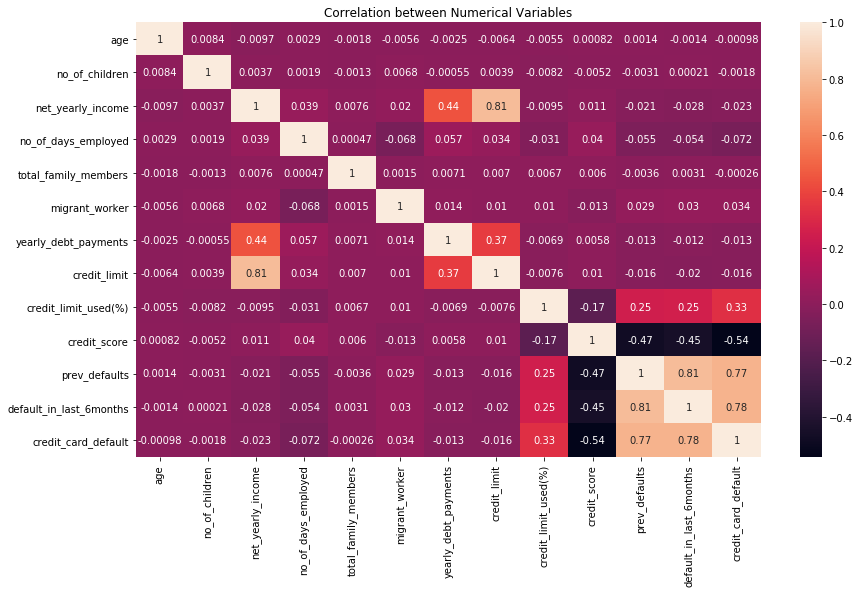

In [104]:
plt.figure(figsize=(14, 8));
plt.title("Correlation between Numerical Variables");
_ = sns.heatmap(train.corr(), annot=True)

1. We can see that credit_limit_used(%), credit_score, prev_defaults and defaults_in_last_6months variables have a high correlation to the dependent variable.
2. We also see that prev_defaults and default_in_last_6months have a strong correlation between themselves. 

### Feature Engineering

In [105]:
train['owns_car'].fillna("Missing",inplace=True)
test['owns_car'].fillna("Missing",inplace=True)

train['no_of_days_employed'].fillna(train['no_of_days_employed'].median(),inplace=True)
test['no_of_days_employed'].fillna(test['no_of_days_employed'].median(),inplace=True)

train['yearly_debt_payments'].fillna(train['yearly_debt_payments'].median(),inplace=True)
test['yearly_debt_payments'].fillna(test['yearly_debt_payments'].median(),inplace=True)

train['credit_score'].fillna(train['credit_score'].median(),inplace=True)
test['credit_score'].fillna(test['credit_score'].median(),inplace=True)

In [106]:
def Credit_Score_Bracket(x):
    if x<600:
        return "Low"
    elif (x>=600 and x<700):
        return "Medium"
    elif (x>=700 and x<800):
        return "High"
    elif (x>=800 and x<900):
        return "Very_High"
    else:
        return "Exceptional"
train['Credit_Score_Bin'] = train['credit_score'].apply(Credit_Score_Bracket)
test['Credit_Score_Bin'] = test['credit_score'].apply(Credit_Score_Bracket)

train['Credit_Score_Bin'] = train['Credit_Score_Bin'].map({"Low":0,"Medium":1,"High":2,"Very_High":3,"Exceptional":4})
test['Credit_Score_Bin'] = test['Credit_Score_Bin'].map({"Low":0,"Medium":1,"High":2,"Very_High":3,"Exceptional":4})


def Credit_Limit_Used_Bracket(x):
    if x<25:
        return "Low"
    elif (x>=25 and x<50):
        return "Medium"
    elif (x>=50 and x<75):
        return "High"
    else:
        return "Very_High"
train['Credit_Used_Bin'] = train['credit_limit_used(%)'].apply(Credit_Limit_Used_Bracket)
test['Credit_Used_Bin'] = test['credit_limit_used(%)'].apply(Credit_Limit_Used_Bracket)

train['Credit_Used_Bin'] = train['Credit_Used_Bin'].map({"Low":0,"Medium":1,"High":2,"Very_High":3})
test['Credit_Used_Bin'] = test['Credit_Used_Bin'].map({"Low":0,"Medium":1,"High":2,"Very_High":3})

In [107]:
train['Credit_Limit_As_Pct_Of_Net_Income'] = (train['credit_limit']/train['net_yearly_income'])*100
test['Credit_Limit_As_Pct_Of_Net_Income'] = (test['credit_limit']/test['net_yearly_income'])*100

train['Yearly_Debt_Payments_As_Pct_Of_Net_Income'] = (train['yearly_debt_payments']/train['net_yearly_income'])*100
test['Yearly_Debt_Payments_As_Pct_Of_Net_Income'] = (test['yearly_debt_payments']/test['net_yearly_income'])*100

train['Credit_Amount_Used'] = (train['credit_limit_used(%)']/100)*train['credit_limit']
test['Credit_Amount_Used'] = (test['credit_limit_used(%)']/100)*test['credit_limit']

train['Credit_Score_Above_700?'] = np.where(train['credit_score']>700,1,0)
test['Credit_Score_Above_700?'] = np.where(test['credit_score']>700,1,0)

train['Yearly_Debt_Payment_As_Pct_Of_Credit_Limit'] = (train['yearly_debt_payments']/train['credit_limit'])*100
test['Yearly_Debt_Payment_As_Pct_Of_Credit_Limit'] = (test['yearly_debt_payments']/test['credit_limit'])*100

train['Credit_Amount_Not_Used'] = train['credit_limit'] - train['Credit_Amount_Used']
test['Credit_Amount_Not_Used'] = test['credit_limit'] - test['Credit_Amount_Used']

train['credit_limit_unused(%)'] = 100 - train['credit_limit_used(%)']
test['credit_limit_unused(%)'] = 100 - test['credit_limit_used(%)']

train['Number_Of_Years_Employed'] = train['no_of_days_employed']/365
test['Number_Of_Years_Employed'] = test['no_of_days_employed']/365

train['Default_in_last_6months_and_previous_defaults'] = np.where(((train['default_in_last_6months']==1)&(train['prev_defaults']>0)),1,0)
test['Default_in_last_6months_and_previous_defaults'] = np.where(((test['default_in_last_6months']==1)&(test['prev_defaults']>0)),1,0)

train['Credit_Amount_Used_As_Pct_Of_Net_Income'] = (train['Credit_Amount_Used']/train['net_yearly_income'])*100
test['Credit_Amount_Used_As_Pct_Of_Net_Income'] = (test['Credit_Amount_Used']/test['net_yearly_income'])*100

train['Amount_Remaining_After_Removing_Debt'] = train['net_yearly_income'] - train['yearly_debt_payments']
test['Amount_Remaining_After_Removing_Debt'] = test['net_yearly_income'] - test['yearly_debt_payments']

In [108]:
# creating grouped features
train['Mean_Net_Yearly_Income_By_Occupation'] = train.groupby('occupation_type')['net_yearly_income'].transform('mean')
train['Median_Net_Yearly_Income_By_Occupation'] = train.groupby('occupation_type')['net_yearly_income'].transform('median')
train['Std_Net_Yearly_Income_By_Occupation'] = train.groupby('occupation_type')['net_yearly_income'].transform('std')

test['Mean_Net_Yearly_Income_By_Occupation'] = test.groupby('occupation_type')['net_yearly_income'].transform('mean')
test['Median_Net_Yearly_Income_By_Occupation'] = test.groupby('occupation_type')['net_yearly_income'].transform('median')
test['Std_Net_Yearly_Income_By_Occupation'] = test.groupby('occupation_type')['net_yearly_income'].transform('std')

In [109]:
train['Mean_Yearly_Debt_Payments_By_Occupation'] = train.groupby('occupation_type')['yearly_debt_payments'].transform('mean')
train['Median_Yearly_Debt_Payments_By_Occupation'] = train.groupby('occupation_type')['yearly_debt_payments'].transform('median')
train['Std_Yearly_Debt_Payments_By_Occupation'] = train.groupby('occupation_type')['yearly_debt_payments'].transform('std')

test['Mean_Yearly_Debt_Payments_By_Occupation'] = test.groupby('occupation_type')['yearly_debt_payments'].transform('mean')
test['Median_Yearly_Debt_Payments_By_Occupation'] = test.groupby('occupation_type')['yearly_debt_payments'].transform('median')
test['Std_Yearly_Debt_Payments_By_Occupation'] = test.groupby('occupation_type')['yearly_debt_payments'].transform('std')

In [110]:
# We see below that there are 238 records where the Number of Years employed is greater than the age. These have to be rectified.
train[train['Number_Of_Years_Employed']>train['age']].head()

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default,Credit_Score_Bin,Credit_Used_Bin,Credit_Limit_As_Pct_Of_Net_Income,Yearly_Debt_Payments_As_Pct_Of_Net_Income,Credit_Amount_Used,Credit_Score_Above_700?,Yearly_Debt_Payment_As_Pct_Of_Credit_Limit,Credit_Amount_Not_Used,credit_limit_unused(%),Number_Of_Years_Employed,Default_in_last_6months_and_previous_defaults,Credit_Amount_Used_As_Pct_Of_Net_Income,Amount_Remaining_After_Removing_Debt,Mean_Net_Yearly_Income_By_Occupation,Median_Net_Yearly_Income_By_Occupation,Std_Net_Yearly_Income_By_Occupation,Mean_Yearly_Debt_Payments_By_Occupation,Median_Yearly_Debt_Payments_By_Occupation,Std_Yearly_Debt_Payments_By_Occupation
27,27,F,N,Y,0,154638.700,10188.000,Core staff,2,0.000,52954.560,20249.080,50,943.000,0,0,0,4,2,13.094,34.244,10124.540,1,261.516,10124.540,50,27.912,0,6.547,101684.140,201782.151,175860.180,102967.048,32711.265,30015.015,17719.845
228,28,F,N,Y,0,89305.350,10739.000,Cooking staff,1,0.000,20763.900,24601.070,9,786.000,0,0,0,2,0,27.547,23.250,2214.096,1,84.402,22386.974,91,29.422,0,2.479,68541.450,161399.980,145715.030,73078.755,28926.194,26773.735,14743.748
384,26,F,Missing,Y,0,181031.370,10622.000,Accountants,2,0.000,50731.570,49489.660,20,862.000,0,0,0,3,0,27.338,28.024,9897.932,1,102.509,39591.728,80,29.101,0,5.468,130299.800,227558.221,200804.385,127895.701,36530.576,33431.440,19529.694
488,29,F,Y,Y,-999,175498.160,11749.000,Laborers,1,0.000,13475.680,27072.010,51,758.000,0,0,0,2,2,15.426,7.679,13806.725,1,49.777,13265.285,49,32.189,0,7.867,162022.480,192233.212,173820.165,86327.872,30964.551,28807.070,15776.999
1111,25,F,N,Y,0,200404.130,9279.000,Core staff,2,0.000,18712.420,48833.880,8,689.000,0,0,0,1,0,24.368,9.337,3906.710,0,38.319,44927.170,92,25.422,0,1.949,181691.710,201782.151,175860.180,102967.048,32711.265,30015.015,17719.845


In [111]:
train.loc[train['Number_Of_Years_Employed']>train['age'],"no_of_days_employed"] = train['no_of_days_employed'].median()
test.loc[test['Number_Of_Years_Employed']>test['age'],"no_of_days_employed"] = test['no_of_days_employed'].median()

In [112]:
# calculating the number of years again
train['Number_Of_Years_Employed'] = train['no_of_days_employed']/365
test['Number_Of_Years_Employed'] = test['no_of_days_employed']/365

In [113]:
num_cols = ['net_yearly_income','no_of_days_employed','yearly_debt_payments','credit_limit','Credit_Amount_Used',
            'Credit_Amount_Not_Used','Amount_Remaining_After_Removing_Debt','Mean_Net_Yearly_Income_By_Occupation',
            'Median_Net_Yearly_Income_By_Occupation','Std_Net_Yearly_Income_By_Occupation','Mean_Yearly_Debt_Payments_By_Occupation',
            'Median_Yearly_Debt_Payments_By_Occupation','Std_Yearly_Debt_Payments_By_Occupation']

for col in num_cols:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])

C:\Users\kulka\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [114]:
le = LabelEncoder()
for col in train.columns:
    if train[col].dtype == "object":
        train[col] = le.fit_transform(train[col])
        test[col] = le.fit_transform(test[col])

In [115]:
cat_cols = ['gender','owns_car','owns_house','occupation_type','migrant_worker','prev_defaults','default_in_last_6months',
            'Default_in_last_6months_and_previous_defaults']

In [116]:
X = train[[col for col in train.columns if col!="credit_card_default"]]
y = train['credit_card_default']

In [117]:
lgb_predictions = np.zeros(test.shape[0])
folds = StratifiedKFold(n_splits=5,random_state=101,shuffle=True)
f_score = []
for train_index,test_index in folds.split(X,y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    clf = lgb.LGBMClassifier(objective='binary',
                             n_jobs=-1,
                             boosting_type="gbdt",
                             learning_rate=0.01,
                             n_estimators=2000,
                             subsample=0.8,
                             colsample_bytree=0.7,
                             reg_lambda=0.5,
                             reg_alpha=0.5,
                             min_child_samples=5,
                             is_unbalanced=True,
                             max_depth=8)
    
    clf.fit(x_train,
            y_train,
            eval_set=[(x_val,y_val)],
            early_stopping_rounds=100,
            verbose=100,
            categorical_feature = cat_cols)
    
    
    preds = clf.predict(x_val)
    score = f1_score(y_val,preds,average='macro')
    print ("Validation F1 Score:",score)
    print ("------------------------------------------------")
    f_score.append(score)
    
    
    # Predicting on the test set
    lgb_predictions += clf.predict(test)
    
print ("------------------------------------------")
print ("Mean F1 Score of 5 Folds:",np.mean(np.array(f_score)))

C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Default_in_last_6months_and_previous_defaults', 'default_in_last_6months', 'gender', 'migrant_worker', 'occupation_type', 'owns_car', 'owns_house', 'prev_defaults']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0926449
[200]	valid_0's binary_logloss: 0.0576153
[300]	valid_0's binary_logloss: 0.0462679
[400]	valid_0's binary_logloss: 0.0422407
[500]	valid_0's binary_logloss: 0.0408223
[600]	valid_0's binary_logloss: 0.0404559
[700]	valid_0's binary_logloss: 0.0404562
Early stopping, best iteration is:
[638]	valid_0's binary_logloss: 0.0404216
Validation F1 Score: 0.9268968362184807
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Default_in_last_6months_and_previous_defaults', 'default_in_last_6months', 'gender', 'migrant_worker', 'occupation_type', 'owns_car', 'owns_house', 'prev_defaults']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0943703
[200]	valid_0's binary_logloss: 0.0602041
[300]	valid_0's binary_logloss: 0.0491629
[400]	valid_0's binary_logloss: 0.045373
[500]	valid_0's binary_logloss: 0.0441316
[600]	valid_0's binary_logloss: 0.043812
[700]	valid_0's binary_logloss: 0.0437627
Early stopping, best iteration is:
[680]	valid_0's binary_logloss: 0.0437199
Validation F1 Score: 0.9222692905450324
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Default_in_last_6months_and_previous_defaults', 'default_in_last_6months', 'gender', 'migrant_worker', 'occupation_type', 'owns_car', 'owns_house', 'prev_defaults']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0911831
[200]	valid_0's binary_logloss: 0.0561262
[300]	valid_0's binary_logloss: 0.0446874
[400]	valid_0's binary_logloss: 0.0407389
[500]	valid_0's binary_logloss: 0.0394882
[600]	valid_0's binary_logloss: 0.0390952
[700]	valid_0's binary_logloss: 0.0391141
Early stopping, best iteration is:
[676]	valid_0's binary_logloss: 0.0390842
Validation F1 Score: 0.9323347699624212
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Default_in_last_6months_and_previous_defaults', 'default_in_last_6months', 'gender', 'migrant_worker', 'occupation_type', 'owns_car', 'owns_house', 'prev_defaults']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0944954
[200]	valid_0's binary_logloss: 0.0596281
[300]	valid_0's binary_logloss: 0.0482368
[400]	valid_0's binary_logloss: 0.0443383
[500]	valid_0's binary_logloss: 0.043139
[600]	valid_0's binary_logloss: 0.0429714
Early stopping, best iteration is:
[576]	valid_0's binary_logloss: 0.04294
Validation F1 Score: 0.9232224554604662
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Default_in_last_6months_and_previous_defaults', 'default_in_last_6months', 'gender', 'migrant_worker', 'occupation_type', 'owns_car', 'owns_house', 'prev_defaults']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0913065
[200]	valid_0's binary_logloss: 0.0562435
[300]	valid_0's binary_logloss: 0.0447736
[400]	valid_0's binary_logloss: 0.0406211
[500]	valid_0's binary_logloss: 0.039175
[600]	valid_0's binary_logloss: 0.0387856
Early stopping, best iteration is:
[597]	valid_0's binary_logloss: 0.0387685
Validation F1 Score: 0.9273010811374761
------------------------------------------------
------------------------------------------
Mean F1 Score of 5 Folds: 0.9264048866647754


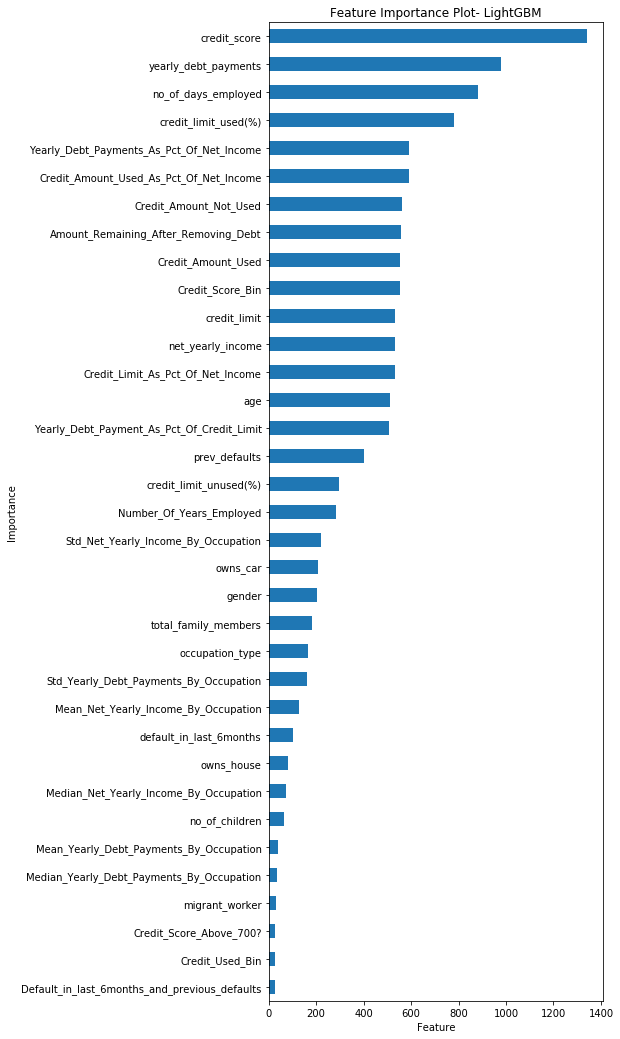

In [118]:
# plotting Feature Importance
plt.figure(figsize=(6,18));
ser = pd.Series(clf.feature_importances_,X.columns).sort_values();
ser.plot(kind='barh');
plt.title("Feature Importance Plot- LightGBM");
plt.xlabel("Feature");
plt.ylabel("Importance");

In [126]:
Submissions['credit_card_default']=lgb_predictions
Submissions['credit_card_default'] = np.where(Submissions['credit_card_default']>=3,1,0)
Submissions.to_csv(r"I:\HackerEarth\AmExpert\Solutions\Solution_61.csv",index=None)

C:\Users\kulka\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kulka\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [127]:
Submissions['credit_card_default'].value_counts()

0    10705
1      678
Name: credit_card_default, dtype: int64

In [121]:
# Local CV Score: 0.9264048866647754
# LB Score: 92.63609